<a href="https://colab.research.google.com/github/aitorvv96/testing_new_things/blob/main/Clasificaci%C3%B3n_de_im%C3%A1genes_con_Python_y_Tensorflow_Redes_Densas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fuente:**
https://www.youtube.com/watch?v=j6eGHROLKP8&list=PLZ8REt5zt2Pn0vfJjTAPaDVSACDvnuGiG&index=2&ab_channel=RingaTech


# **Puntos importantes:**

*   Este es un ejemplo de clasificación de imágenes. Vamos a clasificarlas en 10 categorías (nº neuronas de salida = 10)
*   Vamos a utilizar las dimensiones de imagen más pequeñas (28x28 píxeles), por lo que el nº de neuronas a utilizar será 28x28=784 píxeles (nº neuronas salida = 784)
*   El tipo de red neuronal que se utilizaría aquí sería una convolucional, pero vamos a usar una red densa (más simple)
*   Añadiremos 2 capas ocultas (intermedias) de 50 neuronas
*   Al no ser una relación lineal lo que buscamos, necesitamos una función de activación. En nuestro caso, utilizaremos la denominada ReLU (los números positivos conservan su valor, mientras que todos los negativos se transforman a 0)




In [25]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [26]:
#Descargar set de datos de Fashion MNIST de Zalando
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [3]:
#Imprimir los metadatos para ver que trae el set
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [27]:
#Obtenemos en variables separadas los datos de entrenamiento (60k) y pruebas (10k)
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

In [28]:
#Etiquetas de las 10 categorias posibles
nombres_clases = metadatos.features['label'].names

In [29]:
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [30]:
#Funcion de normalizacion para los datos (Pasar de 0-255 a 0-1)
#Hace que la red aprenda mejor y más rápido
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 #Aqui lo pasa de 0-255 a 0-1
  return imagenes, etiquetas

#Normalizar los datos de entrenamiento y pruebas con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Agregar a cache (usar memoria en lugar de disco, entrenamiento mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

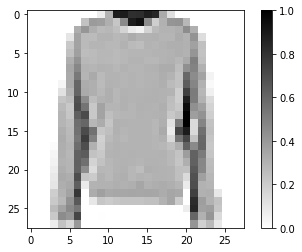

In [31]:
#Mostrar una imagen de los datos de pruebas, de momento mostremos la primera
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((28,28)) #Redimensionar, cosas de tensores, lo veremos despues

import matplotlib.pyplot as plt

#Dibujar dibujar
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

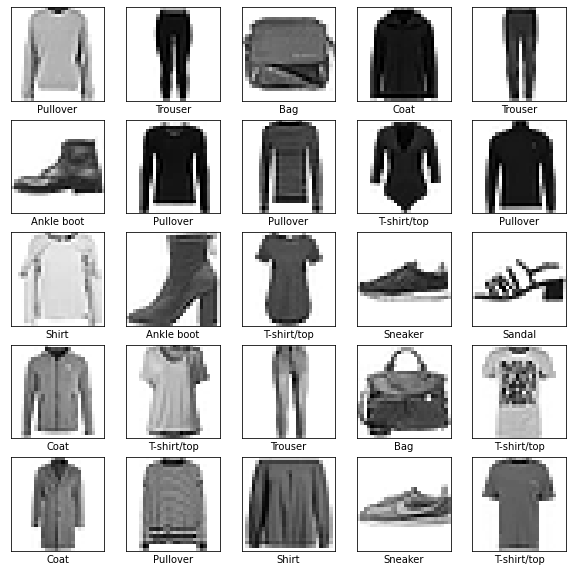

In [32]:
#Dibujar mas
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

# Creación del modelo
Se crea un modelo secuencial, con una primera capa "Flatten", donde se especifica (input_shape) el nº de píxeles y de canales (blanco y negro = 1). Esta capa "Flatten" lo que hace es "aplastar" el contenido de la imagen a una matriz de 784 neuronas.


A continuación, se crean dos capas densas de 50 neuronas cada una con un modo de activación ReLU.


Por último, establecemos la red de salida con 10 neuronas y con la función de activación softmax (utilizada para redes de clasificación).

In [33]:
#Crear el modelo
modelo = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28,1)), #1 - blanco y negro
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax) #Para redes de clasificacion
])

# Compilación del modelo
Para esto, el argumento loss se corresponde con el que se da a una red de clasificación.

In [34]:
#Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [35]:
#Los numeros de datos en entrenamiento y pruebas (60k y 10k)
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples

In [36]:
# Comprobación del nº de datos en entrenamiento y pruebas
print('entrenamiento:', num_ej_entrenamiento)
print('pruebas:', num_ej_pruebas)

entrenamiento: 60000
pruebas: 10000


In [37]:
#El trabajo por lotes permite que entrenamientos con gran cantidad de datos se haga de manera mas eficiente
TAMANO_LOTE = 32

#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria para que la red
#no se vaya a aprender el orden de las cosas
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

# Entrenar el modelo
Para ello se usa la función "fit", proporcionando los datos de entrenamiento, el nº de iteraciones que queremos que haga a los datos (epochs), 

In [38]:
import math

#Entrenar
historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch= math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

Epoch 1/5
1875/1875 [==============================] - 9s 2ms/step - loss: 0.5212 - accuracy: 0.8142
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3879 - accuracy: 0.8607
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3513 - accuracy: 0.8706
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3308 - accuracy: 0.8795
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3060 - accuracy: 0.8869


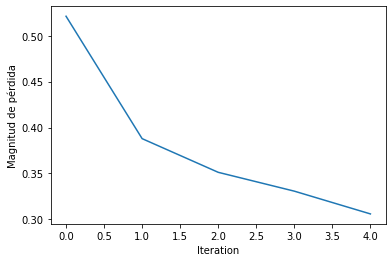

In [39]:
#Ver la funcion de perdida
plt.xlabel("Iteration")  #plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

# Testear predicciones

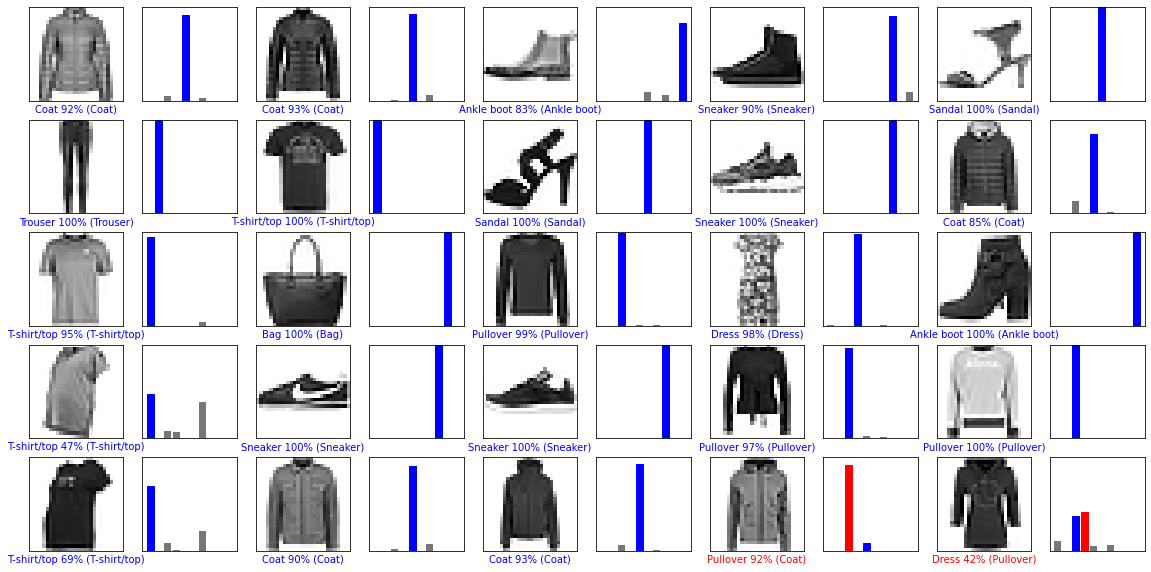

In [40]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)
  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [41]:
#Probar una imagen suelta
imagen = imagenes_prueba[4] #AL ser la variable imagenes_prueba solo tiene lo que se le puso en el bloque anterior heheh
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])])

Prediccion: Sandal


# Exportación del modelo para usarlo en un explorador (no necesario)

In [42]:
#Exportacion del modelo a h5
modelo.save('modelo_exportado.h5')

In [43]:
#Instalar tensorflowjs para convertir el h5 a un modelo que pueda cargar tensorflowjs en un explorador
!pip install tensorflowjs

In [44]:
#Convertir el archivo h5 a formato de tensorflowjs
!mkdir tfjs_target_dir
!tensorflowjs_converter --input_format keras modelo_exportado.h5 tfjs_target_dir

mkdir: cannot create directory ‘tfjs_target_dir’: File exists


In [23]:
#Veamos si si creo la carpeta
!ls

modelo_exportado.h5  sample_data  tfjs_target_dir


In [24]:
#Veamos el contenido de la carpeta
!ls tfjs_target_dir

group1-shard1of1.bin  model.json


Con esto, se prueba a hacer un dibujo y que la red neuronal adivine qué es, pero:


*   Siempre intenta clasificar el dibujo, aunque no se ajuste a los tipos que se le dan
*   Siempre tienen que estar en la misma posición y tener el mismo tamaño, por lo que no es capaz de "aprender" a interpretar la imagen

Para esto se crearon las redes neuronales convolucionales.

